In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import KFold
import os
import time
from sklearn import metrics

In [26]:
from os import listdir
from os.path import isfile, join
from dataclasses import dataclass


@dataclass
class File:
    name: str
    path: str
    lines: list
    label: int
    
    
def readfile(filename):
    with open(filename) as file:
        lines = [line.rstrip()  for line in file if line.strip()]
    return lines


def readdir(dirname):
    files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
    return files


def fileFactory(filename, directory, label):
    fullpath = join(directory, filename)
    return File(filename, fullpath, readfile(fullpath), label)

In [27]:
from enum import IntEnum

fp_dir = '.\git\hacka_2024\FalsePositive'
tp_dir = '.\git\hacka_2024\TruePositive'

class labels(IntEnum):
    truePositive  = 0
    falsePositive = 1

tp_file_names = readdir(tp_dir)
fp_file_names = readdir(fp_dir)

print(tp_file_names)
print(fp_file_names)

tp_files = list()
fp_files = list()

for f in tp_file_names:   
    tp_files.append( fileFactory(f, tp_dir, labels.truePositive) );
   
for f in fp_file_names:   
    fp_files.append( fileFactory(f, fp_dir, labels.falsePositive) );
print(len(tp_files))
print(len(fp_files))

['Abc.java', 'Abs.java', 'AnotherClass1.java', 'AnotherExample5.java', 'AnotherTest4.java', 'AnotherTestClass4.java', 'Auth.java', 'BillieJean.java', 'ByteClass1.java', 'ByteClass3.java', 'ByteComparasion5.java', 'ByteExample2.java', 'CharClass1.java', 'CharClass3.java', 'CharComparison5.java', 'Check.java', 'CustomClass2.java', 'CustomClass4.java', 'CustomTest1.java', 'CustomTest2.java', 'DemoClass.java', 'DemoClassOne.java', 'DemoClassTwo.java', 'DifferentClass6.java', 'DoubleClass1.java', 'DoubleClass3.java', 'DoubleComparison5.java', 'Du.java', 'Example1.java', 'Example2.java', 'Example3.java', 'Example4.java', 'Example5.java', 'ExampleChar2.java', 'ExampleClass2.java', 'ExampleClass3.java', 'ExampleClassTwo.java', 'ExampleDouble2.java', 'ExampleFloat2.java', 'ExampleInt2.java', 'ExampleLong2.java', 'ExampleOne.java', 'ExampleOneOne.java', 'ExampleShort2.java', 'FIfthComparator.java', 'FirstComparator.java', 'FloatClass1.java', 'FloatClass3.java', 'FloatComparison5.java', 'FourthCo

In [28]:
syntax = {
    "{" : 1,
    "}" : 2,
    ";" : 3,
    "(" : 4,
    ")" : 5,
    "[" : 6,
    "]" : 7,
    "<" : 8,
    ">" : 9,
    "," : 10,
    "." : 11
}

keytokens = {
    "abstract" : 0,
    "do" : 0,
    "if" : 0,
    "package" : 0,	
    "synchronized" : 0,
    "implements" : 0,	
    "private" : 0,
    "this" : 0,
    "break": 0,
    "else" : 0,
    "import" : 0,
    "protected" : 0,
    "throw" : 0,
    "extends" : 0,
    "instanceof" : 0,
    "public" : 0,
    "throws" : 0,
    "case" : 0,
    "false" : 0,
    "return" : 0,
    "catch" : 0,
    "final" : 0,
    "interface" : 0,
    "short" : 0,
    "true" : 0,
    "finally" : 0,
    "static" : 0,
    "try" : 0,
    "class" : 0,
    "native" : 0,
    "strictfp" : 0,
    "const" : 0,
    "for" : 0,
    "new" : 0,
    "super" : 0,
    "continue" : 0,
    "goto" : 0,
    "null" : 0,
    "switch" : 0,
    "while" : 0,
    "default" : 0,
    "assert" : 0,
}

buildin_types = {
    "boolean" : 0,
    "double" : 0,
    "float" : 0,
    "long" : 0,
    "char" : 0,
    "int" : 0,
    "void" : 0,
    "byte" : 0,
}

wrapper_types = {
    "Byte" : 0,
    "Short" : 0,
    "Integer" : 0,
    "Long" : 0,
    "Float" : 0,
    "Double" : 0,
    "Boolean" : 0,
    "Character" : 0
}



from collections import namedtuple
from enum        import IntEnum

class TokenType(IntEnum):
    Comment = 0
    Syntax  = 1
    Keyword = 40
    Library = 100
    BuildinType = 200
    Literal = 300
    StringLiteral = 500
    ReferenceType = 2000
    Unknown = 5000


Token  = namedtuple('Token', ['type', 'value'])

def determine_type(value):
    if   value in syntax:
        return TokenType.Syntax
    elif value in keytokens:
        return TokenType.Keyword
    elif value in buildin_types:
        return TokenType.BuildinType
    elif value in wrapper_types:
        return TokenType.ReferenceType
    else:
        return TokenType.Unknown
    

class ParsingError(Exception):
    def __init__(self, message):            
        super().__init__(message)

class UsageError(Exception):
    def __init__(self, message):            
        super().__init__(message)

class  PreParser:
    def __init__(self, file_name):
        self.tokens = []
        self.value  = ""
        self.type   = TokenType.Unknown
        self.char   = 0
        self.file   = open(file_name)

    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        self.file.close()

    def get_result(self):
        return self.tokens
    
    def read_next_char(self):
        self.char = self.file.read(1)
        return self.char

    def peel_next_char(self):
        saved_char = self.char
        if not self.read_next_char():
            self.char, saved_char = saved_char, ''
        else:
            self.char, saved_char = saved_char, self.char
        self.file.seek(self.file.tell() - 1, 0)
        return saved_char

    def add_char(self):
        self.value += self.char

    def end_token(self):
        if not self.value:
            return False
        self.tokens.append( Token(self.type if self.type != TokenType.Unknown else determine_type(self.value), self.value) )
        self.value = ""
        self.type = TokenType.Unknown
        return True

    def is_comment_start(self):
        next_char = self.peel_next_char()
        if next_char == '/' or next_char == '*':
            return True
        return False

    def collapse_comment(self):
        comment = ""
        if   self.char == '/':
            while self.read_next_char():
                if self.char == '\n':
                    self.value = comment
                    self.type  = TokenType.Comment
                    return       
                comment += self.char
        elif self.char == '*':
            while self.read_next_char():
                if self.char == '*':
                    self.read_next_char()
                    self.value = comment
                    self.type  = TokenType.Comment
                    return
                comment += self.char
        else:
            UsageError("PreParser.collapse_comments() shall be called when self.char is on the second symbol of an opening comment sequence.")
        raise ParsingError("Comment is not closed.")
    
    def is_compare(self):
        if self.peel_next_char() == "=":
            return True
        return False

    def collapse_string(self):
        string = ""
        while self.read_next_char():
            if self.char == '"':
                self.value = string
                self.type  = TokenType.StringLiteral
                return
            string += self.char
        raise ParsingError("String literal is not closed.")

    def parse(self):
        while self.read_next_char():
            if self.char.isspace():
                self.end_token()
                continue
 
            if(self.char in syntax):
                self.end_token()
                self.add_char()
                self.end_token()
                continue

            if(self.char == "!" or self.char == "="):
                self.add_char()
                self.type = TokenType.Syntax
                if self.is_compare():
                    self.read_next_char()
                    self.add_char()
                self.end_token()
                continue

            if(self.char == '"'):
                self.collapse_string()
                self.end_token()
                continue

            if(self.char == "/"):
                if not self.is_comment_start():
                    continue
                self.read_next_char()
                self.collapse_comment()
                self.end_token()
                continue

            self.add_char()
        else:
            self.end_token()   

class Parser:
    def __init__(self, tokens):
        self.tokens  = tokens
        self.token   = None
        self.idx     = -1
        self.result  = []
        self.known_user_types = {};

    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        (...)

    def reset(self):
        self.idx   = -1
        self.token = None

    def next(self):
        if self.idx + 1 >= len(self.tokens):
            return None
        self.idx   = self.idx + 1
        self.token = self.tokens[self.idx]
        return self.token
        
    def prev(self):
        if self.idx - 1 < 0:
            return None
        self.idx   = self.idx - 1
        self.token = self.tokens[self.idx]
        return self.token

    def peel_next(self):
        if self.idx + 1 >= len(self.tokens):
            return None 
        return self.tokens[self.idx + 1]

    def get_result(self):
        return self.result
    
    def is_class(self):
        return self.token.value == 'class'
    
    def remember_class(self):
        self.known_user_types[self.token.value] = True

    def is_known_type(self):
        return self.token.value in self.known_user_types
    
    def is_floatable(self):
        try:
            float(self.token.value)
            return True
        except ValueError:
            return False

    def is_intable(self):
        try:
            int(self.token.value)
            return True
        except ValueError:
            return False

    def is_compare(self):
        return self.peel_next() == "="
    
    def parse_bracket(self):
        if self.peel_next().value != "]":
            self.result.append( Token(TokenType.Syntax, self.token.value) )
            return
        t = self.result.pop(-1)
        self.next()
        self.result.append( Token(TokenType.ReferenceType, t.value + "[]") )

    def parse_library(self):
        self.result.append( Token(TokenType.Keyword, self.token.value) )
        s = ""
        while self.next().value != ";":
            s += self.token.value
        self.result.append( Token(TokenType.Library, s) )
        self.result.append( Token(TokenType.Syntax,  ";") )

    def parse(self):
        self.reset()
        while self.next():
            if self.is_class():
                self.next()
                self.remember_class()

        self.reset()
        while self.next():
            if   self.token.value == "[":
                self.parse_bracket()
            elif self.is_known_type():
                self.result.append( Token(TokenType.ReferenceType, self.token.value) )
            elif self.is_floatable():
                self.result.append( Token(TokenType.Literal, float(self.token.value)) )
            elif self.is_intable():
                self.result.append( Token(TokenType.Literal, int(self.token.value)) )
            elif self.token.value == "import":
                self.parse_library()
            else:
                self.result.append(self.token)

In [29]:
counter_dictionary = create_counter_dictionary()
vocabulary = dict()
X = []
y = []

for file in tp_files:
    vector, vocabulary = createVectorFromFileAndUpdateDict(file.path, vocabulary, counter_dictionary)
    X.append(vector)
    y.append(int(file.label))
    
for file in fp_files:
    vector, vocabulary = createVectorFromFileAndUpdateDict(file.path, vocabulary, counter_dictionary)
    X.append(vector)
    y.append(int(file.label))

In [30]:
def generateTokensFromFile(file_path):
    tokens = []
    with PreParser(file_path) as preparser:
        preparser.parse()
        with Parser( preparser.get_result() ) as parser:
            parser.parse()
            for value in parser.get_result():
                tokens.append(value)
    return tokens

In [7]:
def create_counter_dictionary():
    counter_dict = {};
    for tokenType in TokenType: 
        counter_dict[tokenType.name] = 0
    return counter_dict; 

def create_unique_vocabulary(tokens):
    result = []
    for token in tokens:
        if (all(result_token.value != token.value for result_token in result)):
            result.append(token)
    return result

def create_vocabulary_with_weights(tokens, counter_dict, dictionary):
    result = {}; 
    vocabulary_without_weights = create_unique_vocabulary(tokens)

        
    for unique_token in vocabulary_without_weights: 
        if (any(unique_token == token for token in dictionary)):
            continue; 
        
        if (unique_token.type != TokenType.Comment):
            counter_dict[unique_token.type.name] += 1; 
        result[unique_token] = counter_dict[unique_token.type.name] + int(unique_token.type)
    return result

def createVectorFromTokens(tokens, vocabulary_with_weights):
    vector = []
    for token in tokens:
        vector.append(vocabulary_with_weights[token])
    return vector

def createVectorFromFileAndUpdateDict(file_path, dictionary, counter_dictionary):
    tokens = generateTokensFromFile(file_path)
    dictionary.update( create_vocabulary_with_weights(tokens, counter_dictionary, dictionary))
    vector = createVectorFromTokens(tokens, dictionary)
    return vector, dictionary

In [ ]:
from tokenize_all import Java


#doesn't work with labmda-expression
def generateSimpleDictionary(lines): 
    tokens = [];
    
    #ignore whitespace
    for line in lines: 
        tokens.extend([token for token in Java.tokenize(line) if (token.type != 'whitespace')])
    
    #delete value duplicates
    tokens_set = set(tokens)

    unique_tokens_dict = {obj.value: obj for obj in tokens_set}
    unique_tokens_set = set(unique_tokens_dict)
    return unique_tokens_set

In [ ]:
#dictionaryCreator
import re

def generateSimpleDictionary(lines): 
    tokens = [];
    pattern = "[\w']+|[^\w\s']"
    
    for line in lines:
        tokens.extend(re.findall(pattern, line))
        
    #delete value duplicates
    tokens_set = set(tokens)
    return tokens_set


def generateGlobalDictionary(files):
    unique_tokens_dict = set(); 
    for file in files:
        unique_tokens_dict |= generateSimpleDictionary(file.lines)
    return unique_tokens_dict

In [ ]:
#numberVectorCreator
#TODO: сделать так, что для неизвестных символов возвращался -1
def generateVector(lines, enumeratedElements): 
    vector = [];
    pattern = "[\w']+|[^\w\s']"
    
    for line in lines:
        tokens = re.findall(pattern, line)
        vector.extend([enumeratedElements.index(token) for token in tokens])
    return vector

In [ ]:
dictionary_set = generateGlobalDictionary(tp_files)
dictionary_set |= generateGlobalDictionary(fp_files)
enumerated_dictionary = list(dictionary_set)

Xtp, ytp = generateTrainData(tp_files, enumerated_dictionary)
Xfp, yfp = generateTrainData(fp_files, enumerated_dictionary)

Xtp.extend(Xfp)
ytp.extend(yfp)

len(ytp)

n_splits = 5

In [ ]:
def generateTrainData(files, enumerated_dictionary):
    X = []
    y = []
    for file in files: 
        X.append(generateVector(file.lines, enumerated_dictionary))
        y.append(int(file.label))
    return X, y

In [ ]:
def cross_validation(n_splits, X, y, vocabulary, epochs): 
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)
    random_ = 42
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_)

    y_real = []
    X_real = []
    y_pred = []

    for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        print(f"Fold #{fold}")     
        train_x = X[train_index]
        train_y = y[train_index]  
        test_x = X[test_index]
        test_y = y[test_index] 
        
        checkpoint_filepath = f"./model/cross/checkpoint#{fold}.weights.h5"
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                       save_weights_only=True,
                                                                       monitor='loss',
                                                                       mode='min',
                                                                       save_best_only=True)
        model = get_model(len(vocabulary), train_x.shape[1])
        history = model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y), callbacks=[model_checkpoint_callback])
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(test_x)
        X_real.extend(test_x)
        y_real.extend(test_y)
        y_pred.extend(predictions)
    return X_real, y_real, y_pred

In [22]:
def cheater_cross_validation(n_splits, X, y, vocabulary, epochs):
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)
    random_ = 42
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_)

    y_real = []
    X_real = []
    y_pred = []
    for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        print(f"Fold #{fold}")     
        train_x = X[train_index]
        train_y = y[train_index]  
        test_x = X[test_index]
        test_y = y[test_index] 
        checkpoint_filepath = f"./model/cross/checkpointTokenizer#{fold}.weights.h5"
        modelFit(train_x, train_y, vocabulary, epochs, checkpoint_filepath, 0.1)
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(test_x)
        X_real.extend(test_x)
        y_real.extend(test_y)
        y_pred.extend(predictions)
    return X_real, y_real, y_pred

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

#Сюда подается абсолютно вся выборка
def modelFit(X, y, voc, epochs, checkpoint_path, part):
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)

    if (os.path.exists(checkpoint_path)):
        os.remove(checkpoint_path)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=part)
    model = get_model(len(voc), X.shape[1])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])
    
    plt.plot(history.history['val_accuracy'], label="val_accuracy")
    plt.plot(history.history['val_loss'], label="val_loss")
    
    plt.legend()
    plt.show()
    return X_train, X_test, y_train, y_test

Fold #0
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.4729 - loss: 0.8030 - val_accuracy: 0.7143 - val_loss: 0.7942
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6125 - loss: 0.7904 - val_accuracy: 0.4762 - val_loss: 0.7830
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5745 - loss: 0.7727 - val_accuracy: 0.6667 - val_loss: 0.7623
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7895 - loss: 0.7266 - val_accuracy: 0.7619 - val_loss: 0.7153
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9711 - loss: 0.6218 - val_accuracy: 0.9524 - val_loss: 0.5317
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9157 - loss: 0.5592 - val_accuracy: 0.8095 - val_loss: 0.6104
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9384 - loss: 0.4785 - val_accuracy: 0.8095 - val_loss: 0.5407
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.9877 - loss: 0.4258 - val_accuracy: 0.8571 - v

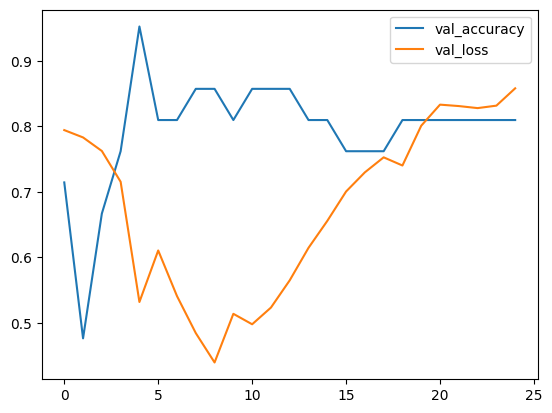

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold #1
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.5059 - loss: 0.7975 - val_accuracy: 0.4286 - val_loss: 0.8371
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5705 - loss: 0.7772 - val_accuracy: 0.4286 - val_loss: 0.7780
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6055 - loss: 0.7583 - val_accuracy: 0.8571 - val_loss: 0.7305
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7768 - loss: 0.6939 - val_accuracy: 0.6667 - val_loss: 0.6411
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8793 - loss: 0.5478 - val_accuracy: 0.7143 - val_loss: 0.6180
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9443 - loss: 0.4118 - val_accuracy: 0.8571 - val_loss: 0.4477
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9636 - loss: 0.3511 - val_accuracy: 0.9524 - val_loss: 0.3418
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9855 - l

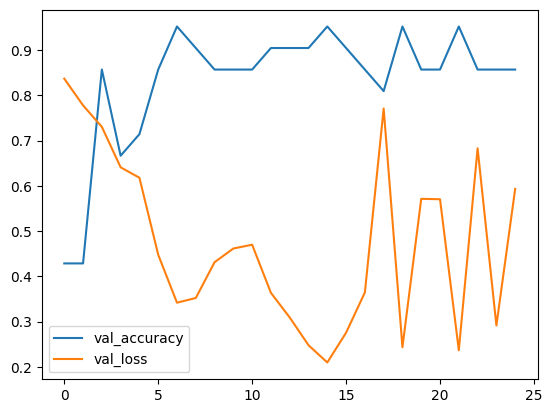

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold #2
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.5432 - loss: 0.8031 - val_accuracy: 0.4286 - val_loss: 0.7975
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.5603 - loss: 0.7894 - val_accuracy: 0.4286 - val_loss: 0.7926
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6200 - loss: 0.7671 - val_accuracy: 0.6667 - val_loss: 0.7473
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7225 - loss: 0.7111 - val_accuracy: 0.8571 - val_loss: 0.6435
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9204 - loss: 0.5406 - val_accuracy: 0.8095 - val_loss: 0.5418
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9447 - loss: 0.4143 - val_accuracy: 0.7143 - val_loss: 0.7253
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9811 - loss: 0.3200 - val_accuracy: 0.7143 - val_loss: 0.7662
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9844 - l

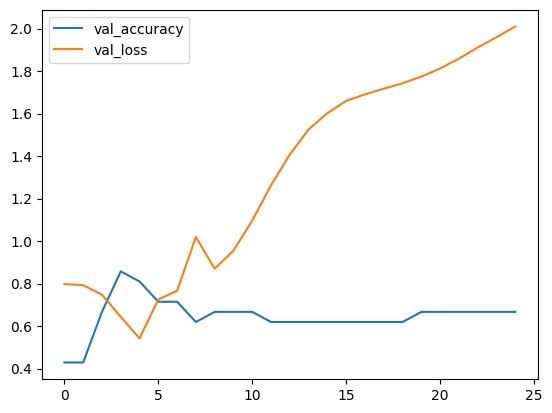

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Fold #3
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.4768 - loss: 0.8016 - val_accuracy: 0.5238 - val_loss: 0.7862
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5120 - loss: 0.7841 - val_accuracy: 0.6190 - val_loss: 0.7512
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6390 - loss: 0.7487 - val_accuracy: 0.8095 - val_loss: 0.6817
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8774 - loss: 0.6336 - val_accuracy: 0.9524 - val_loss: 0.5667
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9775 - loss: 0.4588 - val_accuracy: 0.9048 - val_loss: 0.4836
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9853 - loss: 0.3557 - val_accuracy: 0.8571 - val_loss: 0.4919
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9911 - loss: 0.2882 - val_accuracy: 0.8571 - val_loss: 0.4457
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9926 - l

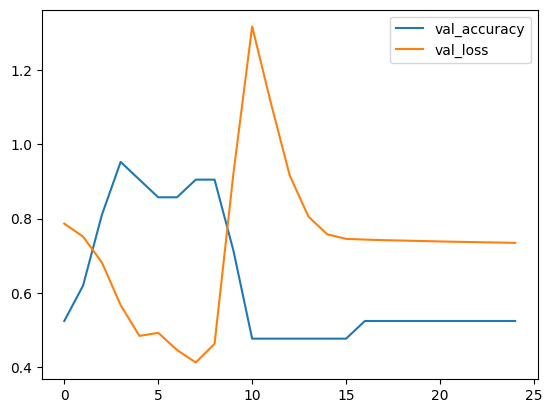

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Fold #4
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.4994 - loss: 0.8021 - val_accuracy: 0.5000 - val_loss: 0.7937
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5047 - loss: 0.7860 - val_accuracy: 0.4545 - val_loss: 0.7793
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.5461 - loss: 0.7462 - val_accuracy: 0.5455 - val_loss: 0.7455
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5890 - loss: 0.6684 - val_accuracy: 0.7273 - val_loss: 0.6922
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7610 - loss: 0.5607 - val_accuracy: 0.5455 - val_loss: 0.7674
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8215 - loss: 0.4992 - val_accuracy: 0.8182 - val_loss: 0.6385
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9359 - loss: 0.4501 - val_accuracy: 0.8636 - val_loss: 0.6543
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9407 - l

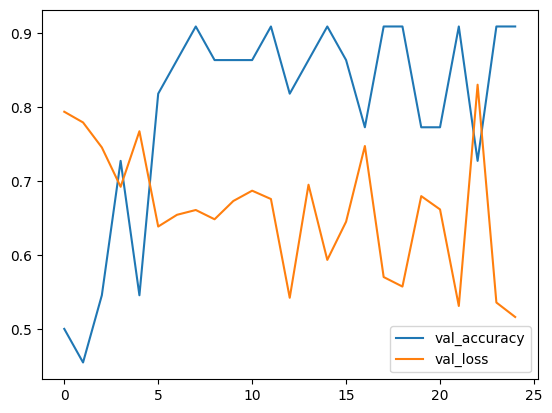

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Fold #5
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.5130 - loss: 0.8023 - val_accuracy: 0.5909 - val_loss: 0.7924
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.4982 - loss: 0.7922 - val_accuracy: 0.6818 - val_loss: 0.7780
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5809 - loss: 0.7755 - val_accuracy: 0.5000 - val_loss: 0.7541
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7410 - loss: 0.7316 - val_accuracy: 0.5455 - val_loss: 0.7101
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8124 - loss: 0.5838 - val_accuracy: 0.7727 - val_loss: 0.6589
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9451 - loss: 0.5218 - val_accuracy: 0.9545 - val_loss: 0.4978
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.9660 - loss: 0.4565 - val_accuracy: 1.0000 - val_loss: 0.4336
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 1.0000 - l

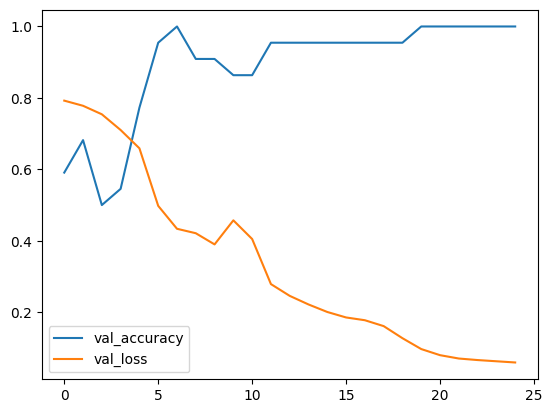

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Fold #6
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.4421 - loss: 0.8027 - val_accuracy: 0.5455 - val_loss: 0.7930
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5941 - loss: 0.7892 - val_accuracy: 0.6818 - val_loss: 0.7799
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6411 - loss: 0.7680 - val_accuracy: 0.7273 - val_loss: 0.7387
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7740 - loss: 0.6983 - val_accuracy: 0.6818 - val_loss: 0.6302
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8956 - loss: 0.5384 - val_accuracy: 0.8636 - val_loss: 0.4800
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9614 - loss: 0.3494 - val_accuracy: 0.8182 - val_loss: 0.4740
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9528 - loss: 0.3118 - val_accuracy: 0.8636 - val_loss: 0.4358
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9935 - l

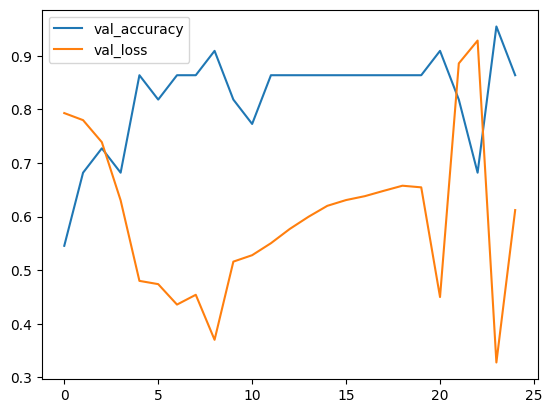

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Fold #7
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.5082 - loss: 0.8041 - val_accuracy: 0.6364 - val_loss: 0.7860
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5962 - loss: 0.7840 - val_accuracy: 0.6818 - val_loss: 0.7392
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7137 - loss: 0.7152 - val_accuracy: 0.7273 - val_loss: 0.6298
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7646 - loss: 0.6016 - val_accuracy: 0.6818 - val_loss: 0.5306
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9097 - loss: 0.4811 - val_accuracy: 0.7273 - val_loss: 0.5603
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9161 - loss: 0.4580 - val_accuracy: 0.8636 - val_loss: 0.4402
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9317 - loss: 0.3627 - val_accuracy: 0.7727 - val_loss: 0.5431
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9523 - l

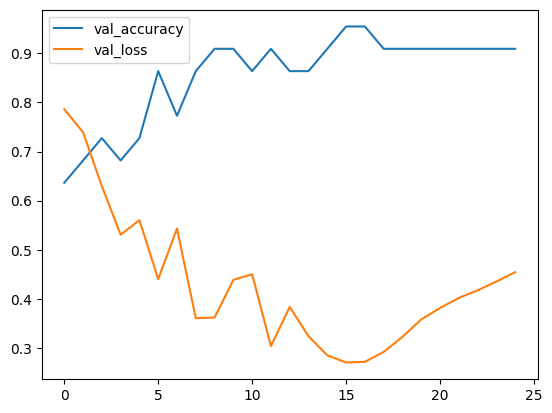

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold #8
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.5201 - loss: 0.8026 - val_accuracy: 0.7273 - val_loss: 0.7913
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5921 - loss: 0.7863 - val_accuracy: 0.6818 - val_loss: 0.7695
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7385 - loss: 0.7440 - val_accuracy: 0.7273 - val_loss: 0.7010
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8384 - loss: 0.6600 - val_accuracy: 0.8182 - val_loss: 0.6147
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8899 - loss: 0.5569 - val_accuracy: 0.7727 - val_loss: 0.5273
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9211 - loss: 0.4406 - val_accuracy: 0.9091 - val_loss: 0.3939
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9766 - loss: 0.3357 - val_accuracy: 0.8182 - val_loss: 0.4442
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9787 - l

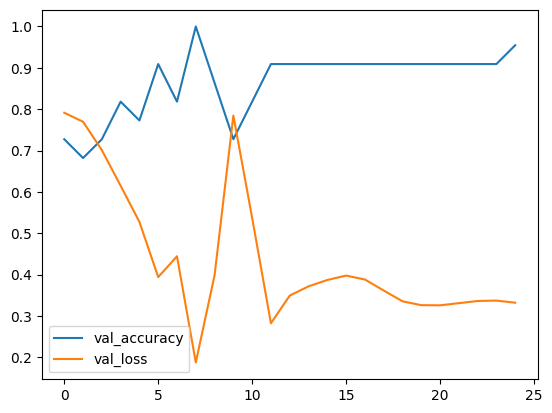

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold #9
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.5183 - loss: 0.8004 - val_accuracy: 0.7273 - val_loss: 0.7847
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6043 - loss: 0.7786 - val_accuracy: 0.8636 - val_loss: 0.7186
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7426 - loss: 0.7264 - val_accuracy: 0.8636 - val_loss: 0.6692
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8252 - loss: 0.5889 - val_accuracy: 0.9091 - val_loss: 0.4893
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8507 - loss: 0.4968 - val_accuracy: 0.8636 - val_loss: 0.4855
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8772 - loss: 0.3988 - val_accuracy: 0.8636 - val_loss: 0.4103
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8890 - loss: 0.3528 - val_accuracy: 0.9545 - val_loss: 0.3277
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9475 - l

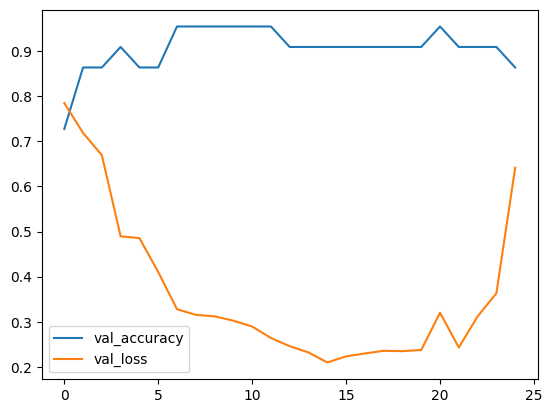

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
TP:  109  TN:  98  FP:  8  FN:  19
Accuracy:  88.46153846153845 %
[0]: 0 - 0
[1]: 0 - 0
[2]: 0 - 1
[3]: 0 - 0
[4]: 0 - 0
[5]: 0 - 0
[6]: 0 - 0
[7]: 0 - 0
[8]: 0 - 1
[9]: 0 - 0
[10]: 0 - 0
[11]: 0 - 0
[12]: 1 - 1
[13]: 1 - 1
[14]: 1 - 1
[15]: 1 - 1
[16]: 1 - 1
[17]: 1 - 1
[18]: 1 - 1
[19]: 1 - 1
[20]: 1 - 1
[21]: 1 - 1
[22]: 1 - 1
[23]: 1 - 1
[24]: 0 - 0
[25]: 0 - 0
[26]: 0 - 0
[27]: 0 - 0
[28]: 0 - 0
[29]: 0 - 0
[30]: 0 - 0
[31]: 0 - 0
[32]: 0 - 0
[33]: 1 - 1
[34]: 1 - 1
[35]: 1 - 1
[36]: 1 - 1
[37]: 1 - 1
[38]: 1 - 1
[39]: 1 - 1
[40]: 1 - 1
[41]: 1 - 1
[42]: 1 - 1
[43]: 1 - 1
[44]: 1 - 1
[45]: 1 - 0
[46]: 1 - 1
[47]: 1 - 1
[48]: 0 - 0
[49]: 0 - 0
[50]: 0 - 0
[51]: 0 - 0
[52]: 0 - 1
[53]: 0 - 0
[54]: 0 - 0
[55]: 0 - 1
[56]: 0 - 0
[57]: 0 - 0
[58]: 0 - 0
[59]: 0 - 0
[60]: 1 - 1
[61]: 1 - 1
[62]: 1 - 1
[63]: 1 - 1
[64]: 1 - 1
[65]: 1 - 1
[66]: 1 - 1
[67]: 1 - 1
[68]: 1 - 1
[69]: 1 - 1
[70]: 1 - 1
[71]: 1 - 1
[72]: 0 - 0
[73]: 0 - 1
[74]: 0 - 0
[75]: 

In [36]:
X_real, y_real, y_pred = cheater_cross_validation(10, X, y, new_vocabulary, 25)
printResults(y_pred, 0.5, y_real)

In [31]:
EPOCHS = 30
batch_size = 2
checkpoint_path = "./model/checkpointTokenizer.weights.h5"
enumerated_dictionary = {}

for token, value in vocabulary.items():
    enumerated_dictionary[token.value] = value

In [32]:
voc = max(enumerated_dictionary.values())
new_vocabulary = []
for i in range(voc):
    for key, value in enumerated_dictionary.items():
        isAdded = False
        if (i == value):
            new_vocabulary.append(key)
            isAdded = True
            break;
    if (isAdded == False):
        new_vocabulary.append("")
counter = 0;
for value in new_vocabulary:
    if (value != ""):
        counter+=1
print(counter)
print(len(new_vocabulary))

616
5362


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.4979 - loss: 0.8015 - val_accuracy: 0.6250 - val_loss: 0.7910
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6581 - loss: 0.7749 - val_accuracy: 0.6250 - val_loss: 0.7212
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7502 - loss: 0.6791 - val_accuracy: 0.8333 - val_loss: 0.5123
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.8978 - loss: 0.4710 - val_accuracy: 0.8750 - val_loss: 0.4655
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9732 - loss: 0.3263 - val_accuracy: 0.8750 - val_loss: 0.4457
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9482 - loss: 0.2767 - val_accuracy: 0.9167 - val_loss: 0.3804
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9750 - loss: 0.2303 - val_accuracy: 0.8750 - val_loss: 0.4108
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9825 - loss: 0.1760 - val_accuracy: 0.8750 - val_loss:

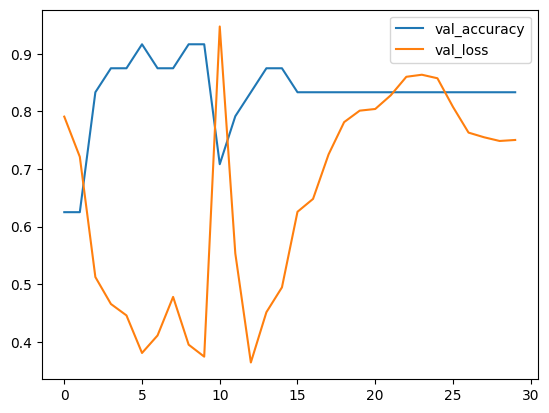

In [33]:
x_train, x_test, y_train, y_test = modelFit(X, y, new_vocabulary, EPOCHS, checkpoint_path, 0.1)

In [34]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
X = np.array(X)
model = loadModel(checkpoint_path, len(new_vocabulary), X.shape[1])
y_pred = model.predict(X)
y_real = y
printResults(y_pred, 0.5, y_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
TP:  116  TN:  112  FP:  1  FN:  5
Accuracy:  97.43589743589743 %
[0]: 0 - 0
[1]: 0 - 0
[2]: 0 - 0
[3]: 0 - 0
[4]: 0 - 0
[5]: 0 - 1
[6]: 0 - 0
[7]: 0 - 0
[8]: 0 - 0
[9]: 0 - 0
[10]: 0 - 0
[11]: 0 - 0
[12]: 0 - 0
[13]: 0 - 0
[14]: 0 - 0
[15]: 0 - 1
[16]: 0 - 0
[17]: 0 - 0
[18]: 0 - 0
[19]: 0 - 0
[20]: 0 - 0
[21]: 0 - 0
[22]: 0 - 0
[23]: 0 - 0
[24]: 0 - 0
[25]: 0 - 0
[26]: 0 - 0
[27]: 0 - 0
[28]: 0 - 0
[29]: 0 - 0
[30]: 0 - 0
[31]: 0 - 0
[32]: 0 - 0
[33]: 0 - 0
[34]: 0 - 0
[35]: 0 - 0
[36]: 0 - 0
[37]: 0 - 0
[38]: 0 - 0
[39]: 0 - 0
[40]: 0 - 0
[41]: 0 - 0
[42]: 0 - 0
[43]: 0 - 0
[44]: 0 - 0
[45]: 0 - 0
[46]: 0 - 0
[47]: 0 - 0
[48]: 0 - 0
[49]: 0 - 0
[50]: 0 - 0
[51]: 0 - 0
[52]: 0 - 0
[53]: 0 - 0
[54]: 0 - 0
[55]: 0 - 0
[56]: 0 - 0
[57]: 0 - 0
[58]: 0 - 0
[59]: 0 - 0
[60]: 0 - 0
[61]: 0 - 0
[62]: 0 - 0
[63]: 0 - 0
[64]: 0 - 0
[65]: 0 - 0
[66]: 0 - 0
[67]: 0 - 0
[68]: 0 - 0
[69]: 0 - 0
[70]: 0 - 1
[71]: 0 - 0
[72]:

In [ ]:
tp_files[6].lines

In [35]:
file = fp_files[6]
demonstrateToken(file, checkpoint_path, vocabulary, new_vocabulary)

public class ByteClassY {
    byte numberB;
    byte otherNumberB;
    public boolean isEqual(ByteClassY someOtherObject) {
        return numberB == someOtherObject.numberB && otherNumberB == someOtherObject.otherNumberB;
    }
}
Пошля возня....
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Ответ шарлатана (ML):
Тут нет ошибки


In [14]:
def demonstrate(file, checkpoint_path, enumerated_dictionary):
    cur_file = file.lines
    y_real = [file.label]
    
    for line in cur_file:
        print(line)
        
    vector = [] 
    #vector.append(generateVector(cur_file, enumerated_dictionary))

    vector.append(createVectorFromTokens(generateTokensFromFile(file.path), enumerated_dictionary))
    
    X = tf.keras.preprocessing.sequence.pad_sequences(vector, padding='pre', value=-1)
    X = np.array(X)

    print("Пошля возня....")
    model = loadModel(checkpoint_path, len(enumerated_dictionary), X.shape[1])
    y_pred = model.predict(X)
    
    classVal = getClassFromBinaryClassification(y_pred, 0.5)
    print("Ответ шарлатана (ML):")
    
    if (classVal == 0):
        print("Тут ошибка")
    else: 
        print("Тут нет ошибки")


def demonstrateToken(file, checkpoint_path, enumerated_dictionary, new_vocabulary):
    cur_file = file.lines
    y_real = [file.label]
    
    for line in cur_file:
        print(line)
        
    vector = [] 
    #vector.append(generateVector(cur_file, enumerated_dictionary))

    vector.append(createVectorFromTokens(generateTokensFromFile(file.path), enumerated_dictionary))
    
    X = tf.keras.preprocessing.sequence.pad_sequences(vector, padding='pre', value=-1)
    X = np.array(X)

    print("Пошля возня....")
    model = loadModel(checkpoint_path, len(new_vocabulary), X.shape[1])
    y_pred = model.predict(X)
    
    classVal = getClassFromBinaryClassification(y_pred, 0.5)
    print("Ответ шарлатана (ML):")
    
    if (classVal == 0):
        print("Тут ошибка")
    else: 
        print("Тут нет ошибки")

In [13]:
def loadModel(weight_file, vocabulary_size, shape):
    model = get_model(vocabulary_size, shape)
    l = []
    l.append(list(np.zeros(shape)))
    l = np.array(l)
    model.predict(l)
    model.load_weights(weight_file)
    return model

#Преобразование вероятности в класс
def getClassFromBinaryClassification(value, thresh): 
    if (value > thresh): 
        return 1
    else:
        return 0

#Вычисление параметра точности
def findAccuracy(y_real, y_pred):
    TP = 0;
    TN = 0; 
    FP = 0; 
    FN = 0;
    for i in range(len(y_real)):
        if (y_real[i] == 1):
            if (y_real[i] == y_pred[i]): 
                TP+=1; 
            else: 
                FP+=1; 
        else:
            if (y_real[i] == y_pred[i]): 
                TN+=1; 
            else: 
                FN+=1; 
    print("TP: ", TP, " TN: ", TN, " FP: ", FP, " FN: ", FN)
    return (TP + TN) / (TP + TN + FP + FN);

#Вывод информации о точности модели, вывод реальных значений классов и распознаных
def printResults(y_pred, thresh, y_real):
    y_pred_class = [getClassFromBinaryClassification(value, thresh) for value in y_pred]
    print("Accuracy: ", findAccuracy(y_real, y_pred_class) * 100, "%")
    for i in range(len(y_pred_class)):
        print("[" + str(i) + "]:" , y_real[i], "-", y_pred_class[i])

In [12]:
def get_model(vocab_size, len): 
    initializer = tf.keras.initializers.GlorotNormal()
    regularizer = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)
    model = tf.keras.Sequential();
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=128, input_length=len))
    model.add(tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(16, return_sequences=False, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model